In [ ]:
# General Config
# Mount google drive
from google.colab import drive  
drive.mount('/content/gdrive')
%cd './gdrive/MyDrive/BigData/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[Errno 2] No such file or directory: './gdrive/MyDrive/BigData/'
/content/gdrive/.shortcut-targets-by-id/16HGMccVbA_xeZio6sQdO6N61Qa0m5LHM/BigData


In [ ]:
# General
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#from helper import *
# SK preprocessing
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import Binarizer

# SK feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# SK pipeline & models
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split


# Keras
# !pip install keras
import keras
import tensorflow
from keras import metrics
from keras import regularizers
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model


In [ ]:
#%cd '/content/gdrive/MyDrive/BigData/Datasets'
filepath = '/content/gdrive/MyDrive/BigData/Datasets/final_train.csv' # './train_users_2.csv'


# Read pandas
data = pd.read_csv(filepath)

print(data.shape) #(213451, 16)


# print(data.head(10))

# nan count in each column
nanCount = data.isnull().sum()
# print(nanCount)

# data.describe()
# print(data.describe())

# Assumption: MM-DD-YYYY - Be read / 3la enha -
# Encode Dates (cyclic data) (sin, cos new dimensions)
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    data = data.drop(columns = [col], axis = 1)
    return data



# Convert columns to datetime objects
data['date_account_created'] = pd.to_datetime(data['date_account_created'])
data['date_first_booking'] = pd.to_datetime(data['date_first_booking'])


#Add date_account_created encoded columns (day,month,year)
data['date_account_created_day'] = data['date_account_created'].dt.day
data['date_account_created_month'] = data['date_account_created'].dt.month
#data['date_account_created_year'] = data['date_account_created'].dt.year


data['date_first_booking_day'] = data['date_first_booking'].dt.day
data['date_first_booking_month'] = data['date_first_booking'].dt.month
#data['date_first_booking_year'] = data['date_first_booking'].dt.year


# Encode dates
data = encode(data, 'date_account_created_day', 365)
data = encode(data, 'date_account_created_month', 12)

data = encode(data, 'date_first_booking_day', 365)
data = encode(data, 'date_first_booking_month', 12) # #(213451, 21)

data = encode(data, 'time_day', 365)
data = encode(data, 'time_month', 12)

data = encode(data, 'time_season', 4)
data = encode(data, 'time_weekday', 7)

#Drop date_first_booking column,date_account_created columns
data = data.drop(columns = ['first_browser','date_first_booking','time_year','date_account_created','Unnamed: 0'], axis = 1) #(213451, 19)


# Replace first_affiliate_tracked with most frequent
frequentModel =data['first_affiliate_tracked'].value_counts()[data['first_affiliate_tracked'].value_counts() == data['first_affiliate_tracked'].value_counts().max()].idxmax()
data['first_affiliate_tracked'] = data['first_affiliate_tracked'].fillna(frequentModel)


# Encode
categ = ['signup_method', 'language', 'affiliate_channel', 'affiliate_provider','first_affiliate_tracked','signup_app', 'first_device_type', 'country_destination', 'gender']

# Encode Categorical Columns
le = LabelEncoder()
data[categ] = data[categ].apply(le.fit_transform)


# Final check for na values
nanCount = data.isnull().sum()
#print(nanCount)

cols_to_norm = ['age_new']
#data[cols_to_norm] = MinMaxScaler().fit_transform(data[cols_to_norm])

# print(data['age'].head(10))
# Correlation: check for feature inter-dependence,

# print(data.head(10))
# corr = data.corr()
print(data.shape)
# print(corr['country_destination'])

data.head(5)


data = data.drop(columns = ['signup_app','time_day_sin', 'time_day_cos','time_month_sin', 'time_month_cos'], axis = 1)
 #(213451, 19)

X = np.asarray(data.loc[:, data.columns != 'country_destination'])
Y = np.asarray(data['country_destination'])
print(X.shape)
X = StandardScaler().fit_transform(X) 


                            

(213451, 21)
(213451, 28)
(213451, 22)


In [ ]:
print(data.shape)
print(data.columns)

(213451, 23)
Index(['gender', 'age', 'signup_method', 'signup_flow', 'language',
       'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked',
       'first_device_type', 'country_destination', 'age_new',
       'date_account_created_day_sin', 'date_account_created_day_cos',
       'date_account_created_month_sin', 'date_account_created_month_cos',
       'date_first_booking_day_sin', 'date_first_booking_day_cos',
       'date_first_booking_month_sin', 'date_first_booking_month_cos',
       'time_month_sin', 'time_month_cos', 'time_season_sin',
       'time_season_cos'],
      dtype='object')


In [ ]:
# Deep Learning
class myCallback(tensorflow.keras.callbacks.Callback): 
  def on_epoch_end(self, epoch, logs={}): 
    ''' 
    Halts the training after reaching 60 percent accuracy 
    Args: 
      epoch (integer) - index of epoch (required but unused in the function definition below) 
      logs (dict) - metric results from the training epoch 
    ''' 
    if(logs.get('accuracy')>0.95): 
      print("\nReached 95% accuracy so cancelling training!") 
      self.model.stop_training = True 
callbacks = myCallback()

X = np.asarray(data.loc[:, data.columns != 'country_destination'])
Y = np.asarray(data['country_destination'])

# Split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=1, shuffle=False)

# Split the data
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2, shuffle= False)

model = Sequential([Flatten(),  
                            Dense(128, activation='relu'),
                            Dense(64, activation='relu'), 
                            Dense(12, activation='softmax')])
model.compile(optimizer = Adam(), 
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy']) 


model.fit(X_train, Y_train, epochs=25, callbacks=[callbacks],
          validation_data=(X_valid, Y_valid),
          batch_size=128)

model.summary()

score = model.evaluate(X_test, Y_test, verbose=0)
score



In [ ]:
# X, Y
#    KNeighborsClassifier(3),
    # SVC(kernel="rbf", C=0.025, probability=True),
    # NuSVC(probability=True),
    # DecisionTreeClassifier(),
    # RandomForestClassifier(),
classifiers = [
    AdaBoostClassifier(),
    #GradientBoostingClassifier(),
    #GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

# Split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=1,shuffle=False)

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, Y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(Y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(Y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

# Ensemble learning
# ensemble = VotingClassifier(classifiers, voting='hard')

# Y_reshaped = Y_train.reshape((len(Y_train), 1))   

# #fit model to training data
# ensemble.fit(X_train, Y_reshaped)

# #test our model on the test data
# ensemble.score(X_test, Y_test)


AdaBoostClassifier
****Results****
Accuracy: 63.4419%
Log Loss: 2.418111424512208
LinearDiscriminantAnalysis
****Results****
Accuracy: 61.7273%
Log Loss: 1.1318515475997946


/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis
****Results****
Accuracy: 80.4549%
Log Loss: 3.90733814254777


Number of feats :  27


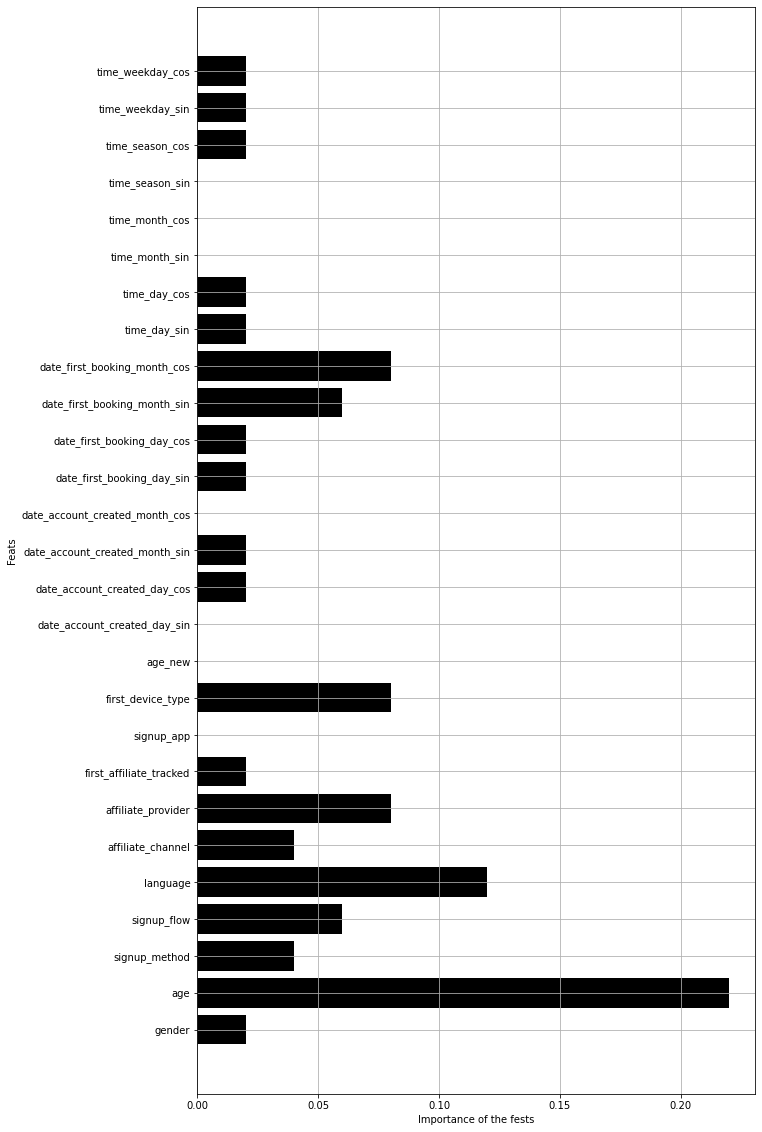

In [ ]:
import matplotlib.pyplot as plt

def plot_feature_importances(clf):
    num_feats = X.shape[1]
    plt.figure(figsize=(10, 20))
    plt.barh(range(num_feats), clf.feature_importances_, color='k', align='center')
    plt.yticks(np.arange(num_feats), X.columns.values)
    plt.xlabel('Importance of the fests')
    plt.ylabel('Feats')
    plt.rcParams["figure.facecolor"] = "white"
    plt.grid(True)

predictors =['gender','age', 'signup_method', 'signup_flow', 'language',
       'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked',
       'signup_app', 'first_device_type', 'age_new',
       'date_account_created_day_sin', 'date_account_created_day_cos',
       'date_account_created_month_sin', 'date_account_created_month_cos',
       'date_first_booking_day_sin', 'date_first_booking_day_cos',
       'date_first_booking_month_sin', 'date_first_booking_month_cos',
       'time_day_sin', 'time_day_cos', 'time_month_sin', 'time_month_cos',
       'time_season_sin', 'time_season_cos', 'time_weekday_sin',
       'time_weekday_cos']
X = data[predictors]
y = data['country_destination']
clf = AdaBoostClassifier()
clf.fit(X,Y )
print('Number of feats : ', X.shape[1])
plot_feature_importances(clf)
plt.rcParams["figure.facecolor"] = "white"